In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
# Explore columns and data structure in Measurement table
first_measurement = session.query(Measurement).first()
first_measurement.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x7faa0e529518>,
 'tobs': 65.0,
 'date': '2010-01-01',
 'id': 1,
 'prcp': 0.08,
 'station': 'USC00519397'}

In [11]:
# Explore columns and data structure in Station table
first_station = session.query(Station).first()
first_station.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x7faa0e59b278>,
 'latitude': 21.2716,
 'station': 'USC00519397',
 'longitude': -157.8168,
 'name': 'WAIKIKI 717.2, HI US',
 'id': 1,
 'elevation': 3.0}

# Exploratory Climate Analysis

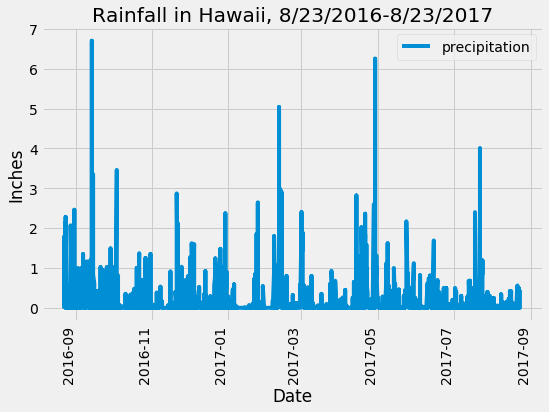

In [29]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
prcp_date = session.query(Measurement.date, Measurement.prcp)

# Calculate the date 1 year ago from the last data point in the database
prcp_date[-1]

# Perform a query to retrieve the data and precipitation scores
prcp_date_last_year = session.query(Measurement.date, Measurement.prcp.label('precipitation')).filter(Measurement.date >= '2016-08-23').all()

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(prcp_date_last_year).fillna(0)
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

# Sort the dataframe by date
df_sorted = df.sort_values('date')
df_sorted

# Use Pandas Plotting with Matplotlib to plot the data
prcp_plot = df_sorted.plot(kind='line', figsize=(8,6), rot=90)
plt.xlabel('Date')
plt.ylabel('Inches')
plt.title('Rainfall in Hawaii, 8/23/2016-8/23/2017')
plt.show()

In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df_sorted.describe()

,precipitation
count,366.000000
mean,0.978907
std,1.776349
min,0.000000
25%,0.052500
50%,0.405000
75%,1.087500
max,14.280000


In [14]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(func.count(Station.id)).all()
station_count

[(9)]

In [15]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_list = session.query(Station.id, Station.station, func.count(Measurement.id)).filter(Station.station==Measurement.station).group_by(Station.station).order_by(func.count(Measurement.id).desc()).all()
station_list

[(7, 'USC00519281', 2772),
 (1, 'USC00519397', 2724),
 (2, 'USC00513117', 2709),
 (6, 'USC00519523', 2669),
 (9, 'USC00516128', 2612),
 (3, 'USC00514830', 2202),
 (8, 'USC00511918', 1979),
 (4, 'USC00517948', 1372),
 (5, 'USC00518838', 511)]

In [16]:
station_df = pd.DataFrame(station_list, columns=['station_id', 'station', 'station_count']).sort_values('station_count', ascending=False)
station_df

,station_id,station,station_count
0,7,USC00519281,2772
1,1,USC00519397,2724
2,2,USC00513117,2709
3,6,USC00519523,2669
4,9,USC00516128,2612
5,3,USC00514830,2202
6,8,USC00511918,1979
7,4,USC00517948,1372
8,5,USC00518838,511


In [17]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
most_active = session.query(Station.station, func.min(Measurement.tobs), func.max(Measurement.tobs), \
                            func.avg(Measurement.tobs)).filter(Station.station==Measurement.station).filter(Station.id == 7).all()
most_active

[('USC00519281', 54.0, 85.0, 71.66378066378067)]

In [18]:
df = pd.DataFrame(most_active, columns=['station', 'min_temp', 'max_temp', 'avg_temp'])
df

,station,min_temp,max_temp,avg_temp
0,USC00519281,54.0,85.0,71.663781


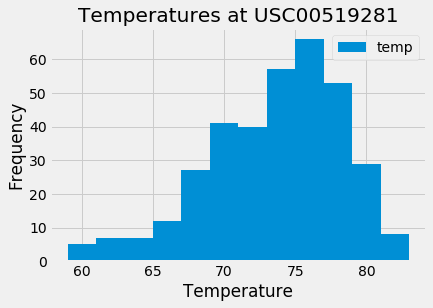

In [19]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_active_tobs = session.query(Station.station, Measurement.tobs).filter(Station.station==Measurement.station).filter(Station.id == 7).filter(Measurement.date >= '2016-08-23')

df = pd.DataFrame(most_active_tobs, columns=['station', 'temp'])
df.plot(kind='hist', bins=12)
plt.title('Temperatures at USC00519281')
plt.xlabel('Temperature')
plt.show()

## Bonus Challenge Assignment

In [20]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [21]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [22]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [23]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [24]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [25]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [26]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [27]:
# Plot the daily normals as an area plot with `stacked=False`
